In [1]:
from Extractor import WaterExtractor
import mdtraj as md
import pickle
from utils_carl import get_mdfps
from scipy.stats import ks_2samp


In [3]:
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'

cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute('SELECT * FROM conformers')
conformers = cur.fetchall()
#get column names
colnames = [desc[0] for desc in cur.description]

In [4]:
#make into df
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
df_confs = pd.DataFrame(conformers,columns= [desc[0] for desc in cur.description])
#for each unique molregno, gert the molblocks, find maximum rmsd between mols. Save row: molregno, confid1, confid2, max_rmsd. We'll make a df from this
molregnos = df_confs.molregno.unique()
max_rmsds = []
confid1s = []
confid2s = []

for molregno in molregnos:
    df_mol = df_confs[df_confs.molregno == molregno]
    molblocks = df_mol.molblock.values
    confids = df_mol.conf_id.values
    max_rmsd = 0
    for i in range(len(molblocks)):
        for j in range(i+1,len(molblocks)):
            mol1 = Chem.MolFromMolBlock(molblocks[i])
            mol2 = Chem.MolFromMolBlock(molblocks[j])
            rmsd = AllChem.GetBestRMS(mol1,mol2)
            if rmsd > max_rmsd:
                max_rmsd = rmsd
                confid1 = confids[i]
                confid2 = confids[j]
    confid1s.append(confid1)
    confid2s.append(confid2)
    max_rmsds.append(max_rmsd)
    print(molregno,max_rmsd)

df_max_rmsds = pd.DataFrame({'molregno':molregnos,'max_rmsd':max_rmsds,'confid1':confid1s,'confid2':confid2s})

2390 1.347750370602337
2396 1.262607148574548
2402 1.0269153907860895
2408 2.030519599318797
2413 1.379178371237664
2417 1.7958117826831443
2455 0
2391 1.7983789020380065
2397 1.8180443739283512
2403 0.015705983020873976
2409 2.216768529843168
2414 1.867783176650237
2418 2.1538668245421664
2461 0.006792089373729867
2392 1.4001471240484755
2398 4.362389969694689
2404 2.7970280758146084
2410 2.355476928518368
2415 0.7190163466967062
2419 0.03851436684125
2393 1.5856236438936868
2399 0.2950320859707816
2405 0.6665384745084292
2411 1.2070595903464905
2416 1.6971952595178903
2422 0.041539131993973015
2394 1.7032947600664328
2400 0.730912370915651
2406 2.1745048464293153
2636 0.029362699654061384
7 1.8136680620174745
8 0.08004868858696823
9 1.0702923569178018
10 0.35908058238562124
11 0.03452504009559615
12 1.0541152589030391
13 1.0255372981227475
14 0.03570047505636963
15 0.5827094350504699
16 3.77637869644601
17 2.7112127331516396
18 0.9813917436432119
19 0.6838854669834068
20 0.0507285428

KeyboardInterrupt: 

In [ ]:
df_max_rmsds
#drop zeros
df_max_rmsds_nz = df_max_rmsds[df_max_rmsds.max_rmsd != 0]
df_max_rmsds_nz.to_csv('max_rmsds_confs.csv')

In [11]:
df_max_rmsds_nz = pd.read_csv('max_rmsds_confs.csv',index_col=0)

In [12]:
df_max_rmsds_nz

,molregno,max_rmsd,confid1,confid2
0,2390,1.347750,8195,8197
1,2396,1.262607,2394,8525
2,2402,1.026915,2400,12223
3,2408,2.030520,2406,15329
4,2413,1.379178,8224,8225
...,...,...,...,...
3023,1087,1.928616,9888,9889
3024,1088,0.041491,4244,10981
3027,9978,2.338576,9976,9978
3031,15648,4.825195,15648,15649


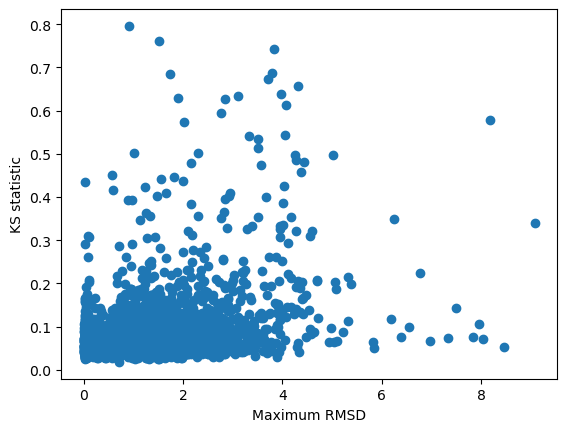

PearsonRResult(statistic=0.3387923603183398, pvalue=5.3821656337363055e-79)
SignificanceResult(statistic=0.2566613745579794, pvalue=5.916844308832261e-45)


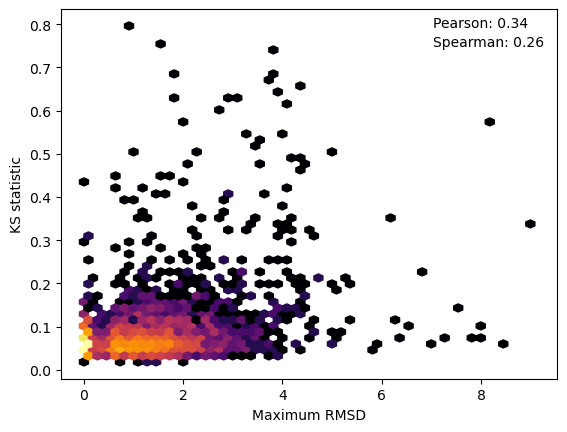

Text(0, 0.5, 'KS statistic')

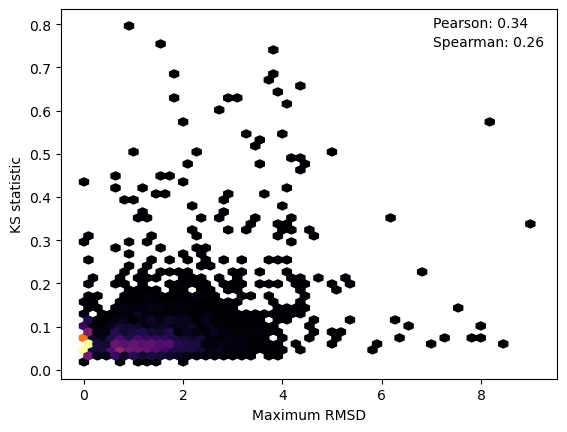

In [43]:
df_ks_stats = pd.read_csv('ks_stat.csv',index_col=0)
df_ks_stats
#merge on confid1 and confid2 with df_max_rmsds_nz
df_merged = df_ks_stats.merge(df_max_rmsds_nz,how='inner',on=['confid1','confid2'])
df_merged
#plot max_rmsd against ks_stat
import matplotlib.pyplot as plt
plt.scatter(df_merged.max_rmsd,df_merged.ks_stat)
plt.xlabel('Maximum RMSD')
plt.ylabel('KS statistic')
plt.savefig('max_rmsd_vs_ks_stat.png')
plt.show()
#print some correlation statistics
from scipy.stats import pearsonr
from scipy.stats import spearmanr
print(pearsonr(df_merged.max_rmsd,df_merged.ks_stat))
print(spearmanr(df_merged.max_rmsd,df_merged.ks_stat))
#plot hexbin
plt.hexbin(df_merged.max_rmsd,df_merged.ks_stat,gridsize=50,bins='log',cmap='inferno',mincnt=1)
#add pearson and spearman correlation as text
plt.text(0.75,0.95,'Pearson: %.2f'%pearsonr(df_merged.max_rmsd,df_merged.ks_stat)[0],transform=plt.gca().transAxes)
plt.text(0.75,0.9,'Spearman: %.2f'%spearmanr(df_merged.max_rmsd,df_merged.ks_stat)[0],transform=plt.gca().transAxes)
plt.xlabel('Maximum RMSD')
plt.ylabel('KS statistic')
plt.show()

plt.hexbin(df_merged.max_rmsd,df_merged.ks_stat,gridsize=50,cmap='inferno',mincnt=1)
#add pearson and spearman correlation as text
plt.text(0.75,0.95,'Pearson: %.2f'%pearsonr(df_merged.max_rmsd,df_merged.ks_stat)[0],transform=plt.gca().transAxes)
plt.text(0.75,0.9,'Spearman: %.2f'%spearmanr(df_merged.max_rmsd,df_merged.ks_stat)[0],transform=plt.gca().transAxes)
plt.xlabel('Maximum RMSD')
plt.ylabel('KS statistic')


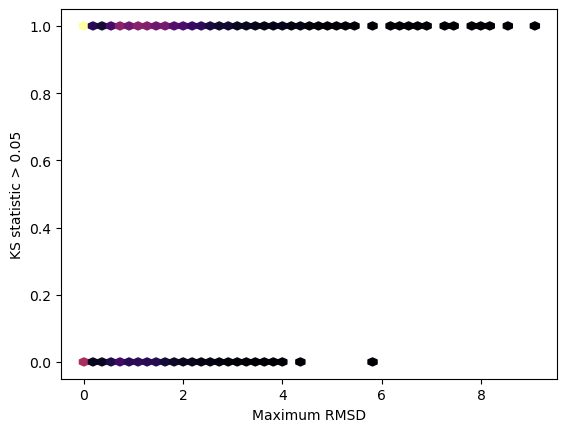

In [41]:
#lets also look at a binary: is the ks_stat > 0.05 or not?
df_merged['ks_stat_bin'] = df_merged.ks_stat > 0.05
df_merged
#plot max_rmsd against ks_stat
import matplotlib.pyplot as plt
plt.hexbin(df_merged.max_rmsd,df_merged.ks_stat_bin,gridsize=50,cmap='inferno',mincnt=1)
plt.xlabel('Maximum RMSD')
plt.ylabel('KS statistic > 0.05')
plt.savefig('max_rmsd_vs_ks_stat_bin.png')  
plt.show()

In [49]:
#check: sort by max rmsd (descending)
df_merged.sort_values(by='ks_stat',ascending=False)
#lets look at these: 2361	7712, cherck rmsd and ks stat


,confid1,confid2,ks_stat,ks_pvals,molregno,max_rmsd
1377,12383,12384,0.796,2.277021e-57,2586,0.901306
791,1955,10891,0.760,6.478484e-142,810,1.520398
410,1538,4952,0.742,2.646290e-134,393,3.837752
887,9472,9473,0.688,2.816297e-113,916,3.784200
696,15214,15215,0.684,8.077774e-112,686,1.731569
...,...,...,...,...,...,...
2352,7153,7155,0.024,9.987737e-01,3614,1.508026
804,14889,14892,0.024,9.987737e-01,802,1.300646
1053,9938,9940,0.024,9.987737e-01,1058,1.500799
2863,15189,15190,0.024,9.987737e-01,4192,1.026663


In [ ]:
#first: check to see if this is legit.

In [6]:
confid2 = 4275

try:
    traj2 = md.load(f"trajectories/fc57851e-b654-4338-bcdd-faa28ec66253/{confid2}.h5")
    rdk_pmd2 = pickle.load(open(f"topologies/fc57851e-b654-4338-bcdd-faa28ec66253/{confid2}.pickle", "rb"))
except OSError as e:
    try:
        traj2 = md.load(f"trajectories/e0f120fb-efa9-4c88-a964-e7b99253027c/{confid2}.h5")
        rdk_pmd2 = pickle.load(open(f"topologies/e0f120fb-efa9-4c88-a964-e7b99253027c/{confid2}.pickle", "rb"))
    except OSError as e:
        pass


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [17]:
f_max_rmsds_nz = pd.read_csv('max_rmsds_confs.csv',index_col=0)
confid1 = 8195
confid2= 8197


traj1 = md.load(f"{confid1}.h5")
rdk_pmd1 = pickle.load(open(f"{confid1}.pickle", "rb"))
print('found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1')

energie_dict1 = WaterExtractor.extract_energies(mdtraj_obj=traj1,parmed_obj=rdk_pmd1)
water_total_ene1 = energie_dict1["water_total_ene"]


traj2 = md.load(f"{confid2}.h5")
rdk_pmd2 = pickle.load(open(f"{confid2}.pickle", "rb"))
print('found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid2')

energie_dict2 = WaterExtractor.extract_energies(mdtraj_obj=traj2,parmed_obj=rdk_pmd2)
water_total_ene2 = energie_dict2["water_total_ene"]
#get KS statistic
ks_statistic, p_value = ks_2samp(water_total_ene1,water_total_ene2)
print(ks_statistic,p_value)


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid2
0.212 2.9997941681975455e-10


(array([ 1.,  0.,  1.,  2.,  0.,  3.,  0.,  0.,  2.,  0.,  3.,  2.,  1.,
         4.,  3.,  2.,  6.,  3.,  3.,  3.,  6.,  1.,  3.,  6.,  5.,  8.,
        10.,  8.,  8.,  8., 13.,  6., 11.,  9., 13., 11.,  9.,  8., 14.,
        13.,  8.,  8., 14., 10., 12., 10.,  8.,  8.,  9., 13.,  9.,  6.,
         9.,  6.,  5.,  8.,  7., 10.,  8.,  6.,  8.,  4.,  4.,  9.,  5.,
         4.,  9.,  5.,  8.,  5.,  6.,  5., 10.,  3.,  3.,  1.,  2.,  1.,
         2.,  2.,  5.,  1.,  1.,  1.,  4.,  0.,  0.,  2.,  0.,  0.,  0.,
         1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.]),
 array([-94.42508977, -93.90385767, -93.38262557, -92.86139347,
        -92.34016137, -91.81892927, -91.29769716, -90.77646506,
        -90.25523296, -89.73400086, -89.21276876, -88.69153665,
        -88.17030455, -87.64907245, -87.12784035, -86.60660825,
        -86.08537614, -85.56414404, -85.04291194, -84.52167984,
        -84.00044774, -83.47921563, -82.95798353, -82.43675143,
        -81.91551933, -81.39428723, -80.87305512, 

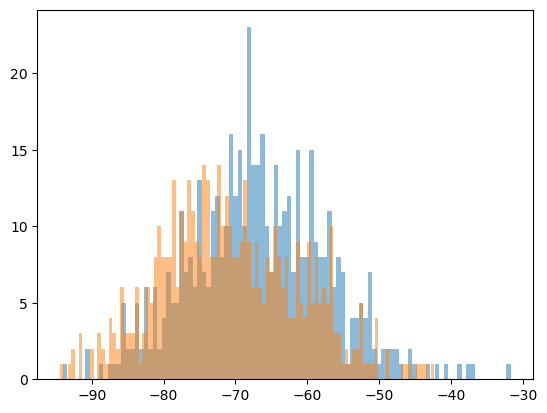

In [19]:
#plot them as histograms
import matplotlib.pyplot as plt
plt.hist(water_total_ene1,bins=100,alpha=0.5,label='confid1')
plt.hist(water_total_ene2,bins=100,alpha=0.5,label='confid2')

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid2
0.07 0.1725563396262406


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  1.,  2.,  0.,  4.,  2.,
         3.,  3.,  9.,  1.,  3.,  6.,  8.,  9., 11., 13., 13., 14.,  9.,
        16., 20., 13., 20., 21., 19., 19., 12., 15., 15., 18., 14., 11.,
         8., 12., 11., 19.,  9., 11., 14., 14., 11.,  5., 10.,  7.,  6.,
         9.,  1.,  3.,  3.,  5.,  1.,  1.,  1.,  0.,  2.,  1.,  2.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-291.3242283 , -289.77972723, -288.23522615, -286.69072508,
        -285.146224  , -283.60172293, -282.05722186, -280.51272078,
        -278.96821971, -277.42371864, -275.87921756, -274.33471649,
        -272.79021541, -271.24571434, -269.70121327, -268.15671219,
        -266.61221112, -265.06771005, -263.52320897, -261.9787079 ,
        -260.43420682, -258.88970575, -257.34520468, -255.8007036 ,
        -254.25620253, -25

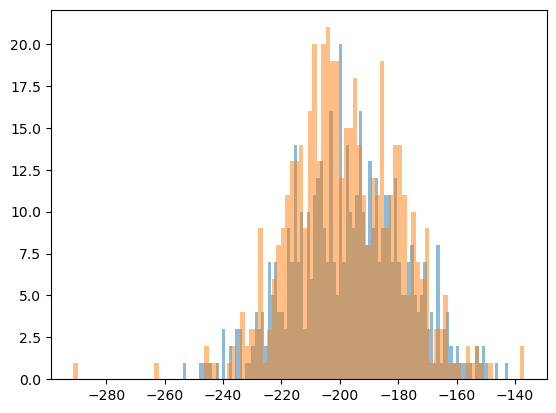

In [23]:
f_max_rmsds_nz = pd.read_csv('max_rmsds_confs.csv',index_col=0)
confid1 = 2361
confid2= 7712


traj1 = md.load(f"{confid1}.h5")
rdk_pmd1 = pickle.load(open(f"{confid1}.pickle", "rb"))

energie_dict1 = WaterExtractor.extract_energies(mdtraj_obj=traj1,parmed_obj=rdk_pmd1)
water_total_ene1 = energie_dict1["water_total_ene"]

traj2 = md.load(f"{confid2}.h5")
rdk_pmd2 = pickle.load(open(f"{confid2}.pickle", "rb"))

energie_dict2 = WaterExtractor.extract_energies(mdtraj_obj=traj2,parmed_obj=rdk_pmd2)
water_total_ene2 = energie_dict2["water_total_ene"]
#get KS statistic
ks_statistic, p_value = ks_2samp(water_total_ene1,water_total_ene2)
print(ks_statistic,p_value)
#plot them as histograms
import matplotlib.pyplot as plt
plt.hist(water_total_ene1,bins=100,alpha=0.5,label='confid1')
plt.hist(water_total_ene2,bins=100,alpha=0.5,label='confid2')

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


0.796 2.2770213737391564e-57
500 106


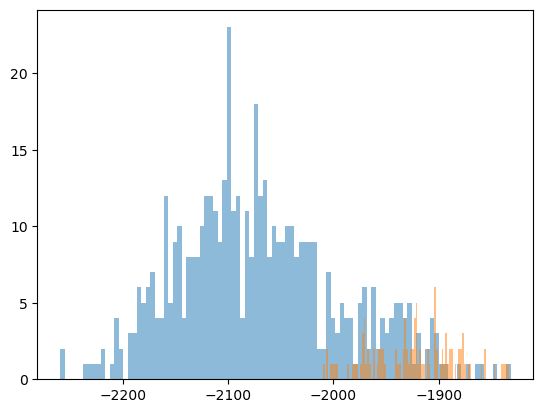

In [51]:
f_max_rmsds_nz = pd.read_csv('max_rmsds_confs.csv',index_col=0)
confid1 = 12383
confid2= 12384


traj1 = md.load(f"{confid1}.h5")
rdk_pmd1 = pickle.load(open(f"{confid1}.pickle", "rb"))

energie_dict1 = WaterExtractor.extract_energies(mdtraj_obj=traj1,parmed_obj=rdk_pmd1)
water_total_ene1 = energie_dict1["water_total_ene"]

traj2 = md.load(f"{confid2}.h5")
rdk_pmd2 = pickle.load(open(f"{confid2}.pickle", "rb"))

energie_dict2 = WaterExtractor.extract_energies(mdtraj_obj=traj2,parmed_obj=rdk_pmd2)
water_total_ene2 = energie_dict2["water_total_ene"]
#get KS statistic
ks_statistic, p_value = ks_2samp(water_total_ene1,water_total_ene2)
print(ks_statistic,p_value)
#plot them as histograms
import matplotlib.pyplot as plt
plt.hist(water_total_ene1,bins=100,alpha=0.5,label='confid1')
plt.hist(water_total_ene2,bins=100,alpha=0.5,label='confid2')
print(len(water_total_ene1),len(water_total_ene2))
import psycopg2
from rdkit.Chem import Draw

hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
#select conformers with conf_id 7712 and 2361
cur.execute("SELECT * FROM conformers WHERE conf_id = 7712 OR conf_id = 2361")
results = cur.fetchall()
results
mols = [Chem.MolFromMolBlock(result[3]) for result in results]
Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
#draw

In [33]:
#print mean, median and std for both
import numpy as np
print(np.mean(water_total_ene1),np.median(water_total_ene1),np.std(water_total_ene1))
print(np.mean(water_total_ene2),np.median(water_total_ene2),np.std(water_total_ene2))

-196.93884642374854 -197.24768761519715 19.24531102161764
-198.18033446561836 -199.7667804189377 18.661500412307205


In [4]:
import psycopg2
from rdkit.Chem import Draw

hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
#select conformers with conf_id 7712 and 2361
cur.execute("SELECT * FROM conformers WHERE conf_id = 7712 OR conf_id = 2361")
results = cur.fetchall()
results
mols = [Chem.MolFromMolBlock(result[3]) for result in results]
Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
#draw

NameError: name 'Chem' is not defined

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


0.76 6.4784842130379276e-142
500 500


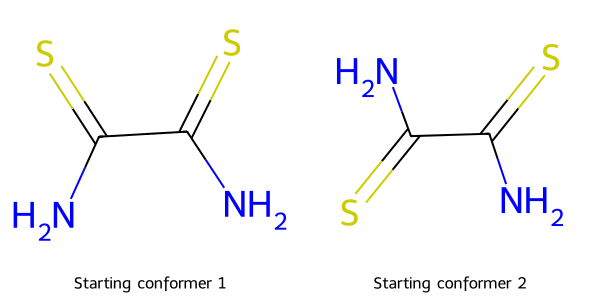

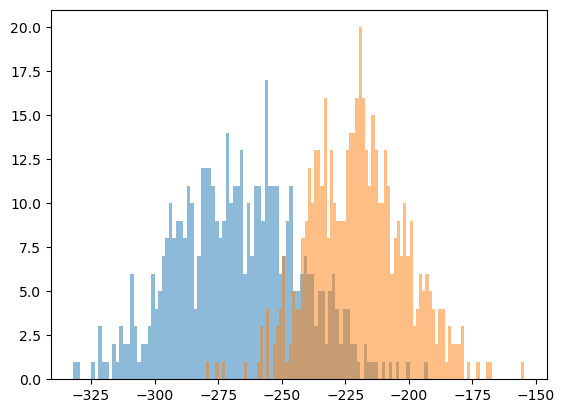

In [6]:
import pandas as pd
from rdkit import Chem
f_max_rmsds_nz = pd.read_csv('max_rmsds_confs.csv',index_col=0)
confid1 = 1955
confid2= 10891


traj1 = md.load(f"{confid1}.h5")
rdk_pmd1 = pickle.load(open(f"{confid1}.pickle", "rb"))

energie_dict1 = WaterExtractor.extract_energies(mdtraj_obj=traj1,parmed_obj=rdk_pmd1)
water_total_ene1 = energie_dict1["water_total_ene"]

traj2 = md.load(f"{confid2}.h5")
rdk_pmd2 = pickle.load(open(f"{confid2}.pickle", "rb"))

energie_dict2 = WaterExtractor.extract_energies(mdtraj_obj=traj2,parmed_obj=rdk_pmd2)
water_total_ene2 = energie_dict2["water_total_ene"]
#get KS statistic
ks_statistic, p_value = ks_2samp(water_total_ene1,water_total_ene2)
print(ks_statistic,p_value)
#plot them as histograms
import matplotlib.pyplot as plt
plt.hist(water_total_ene1,bins=100,alpha=0.5,label='confid1')
plt.hist(water_total_ene2,bins=100,alpha=0.5,label='confid2')
print(len(water_total_ene1),len(water_total_ene2))

cur.execute(f"SELECT * FROM conformers WHERE conf_id = {confid1} OR conf_id = {confid2}")
results = cur.fetchall()
results
mols = [Chem.MolFromMolBlock(result[3]) for result in results]
Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
#draw

In [74]:
mols

2
[<rdkit.Chem.rdchem.Mol object at 0x7fbab8291b60>, <rdkit.Chem.rdchem.Mol object at 0x7fbab831f220>]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

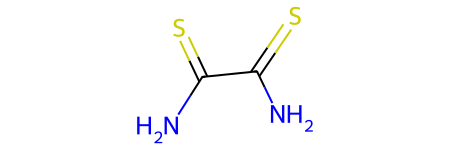

In [7]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
def drawit(ms, p=None, confId=-1, removeHs=True,colors=('cyanCarbon','redCarbon','blueCarbon')):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for i,m in enumerate(ms):
            if removeHs:
                m = Chem.RemoveHs(m)
            IPythonConsole.addMolToView(m,p,confId=confId)
        for i,m in enumerate(ms):
            p.setStyle({'model':i,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()
print(len(mols))
print(mols)
#align
from rdkit.Chem import AllChem
AllChem.AlignMol(mols[0],mols[1])
IPythonConsole.ipython_3d = True
mols[0]

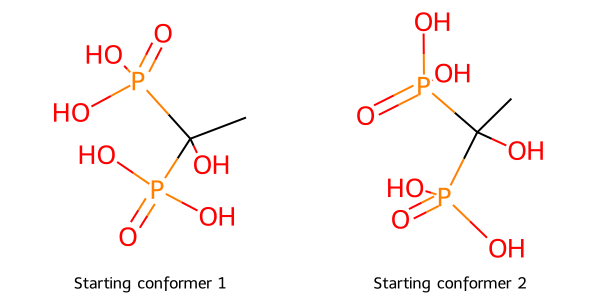

In [53]:
import psycopg2
from rdkit.Chem import Draw

hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
#select conformers with conf_id 7712 and 2361
cur.execute("SELECT * FROM conformers WHERE conf_id = 12383 OR conf_id = 12384")
results = cur.fetchall()
results
mols = [Chem.MolFromMolBlock(result[3]) for result in results]
Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
#draw

In [8]:
confid1_saved,confid2_saved,ks_stat,ks_pvals = [],[],[],[]
for confid1,confid2 in zip(confid1s,confid2s):
    # print(confid1,confid2)
    try:
        traj1 = md.load(f"trajectories/fc57851e-b654-4338-bcdd-faa28ec66253/{confid1}.h5")
        rdk_pmd1 = pickle.load(open(f"topologies/fc57851e-b654-4338-bcdd-faa28ec66253/{confid1}.pickle", "rb"))
    except OSError as e:
        try:
            traj1 = md.load(f"trajectories/e0f120fb-efa9-4c88-a964-e7b99253027c/{confid1}.h5")
            rdk_pmd1 = pickle.load(open(f"topologies/e0f120fb-efa9-4c88-a964-e7b99253027c/{confid1}.pickle", "rb"))
            print('found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1')
        except OSError as e:
            continue


    energie_dict1 = WaterExtractor.extract_energies(mdtraj_obj=traj1,parmed_obj=rdk_pmd1)
    water_total_ene1 = energie_dict1["water_total_ene"]

    try:
        traj2 = md.load(f"trajectories/fc57851e-b654-4338-bcdd-faa28ec66253/{confid2}.h5")
        rdk_pmd2 = pickle.load(open(f"topologies/fc57851e-b654-4338-bcdd-faa28ec66253/{confid2}.pickle", "rb"))
    except OSError as e:
        try:
            traj2 = md.load(f"trajectories/e0f120fb-efa9-4c88-a964-e7b99253027c/{confid2}.h5")
            rdk_pmd2 = pickle.load(open(f"topologies/e0f120fb-efa9-4c88-a964-e7b99253027c/{confid2}.pickle", "rb"))
            print('found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid2')
        except OSError as e:
            continue

    energie_dict2 = WaterExtractor.extract_energies(mdtraj_obj=traj2,parmed_obj=rdk_pmd2)
    water_total_ene2 = energie_dict2["water_total_ene"]
    #get KS statistic
    ks_statistic, p_value = ks_2samp(water_total_ene1,water_total_ene2)
    print(ks_statistic,p_value)
    confid1_saved.append(confid1)
    confid2_saved.append(confid2)
    ks_stat.append(ks_statistic)
    ks_pvals.append(p_value)
print(confid1_saved,confid2_saved,ks_stat,ks_pvals)
#make df
df_ks = pd.DataFrame({'confid1':confid1_saved,'confid2':confid2_saved,'ks_stat':ks_stat,'ks_pvals':ks_pvals})
#to csv
df_ks.to_csv('ks_stat.csv')


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1
found in e0f120fb-efa9-4c88-a964-e7b99253027c for confid1


KeyboardInterrupt: 

In [30]:
df_one =get_mdfps("one_5ns")
df_many =get_mdfps("five_5ns")
molregnos = df_one["molregno"].unique()
molregnos = molregnos.tolist()
confids_one,confids_many = [],[]
for m in molregnos:
    one_confid = df_one[df_one["molregno"]==m]["confid"].unique()
    if len(one_confid) == 1:
        one_confid = one_confid[0]
    else:
        print("error")
    many_confid = df_many[df_many["molregno"]==m]["confid"].unique()
    confids_one.append(one_confid.tolist())
    confids_many.append(many_confid.tolist())
print(len(confids_one),len(confids_many))

2980 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']
11023 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']
2980 2980


In [3]:
df_many

,confid,molregno,mdfp,vp
0,5913,3831,"[11, 0, 1, 1, 0, 0, 0, 0, 0, 0, -320.430381442...",-0.585027
1,5896,3076,"[14, 5, 0, 1, 0, 0, 0, 0, 0, 0, -115.251545263...",0.407731
2,5895,3076,"[14, 5, 0, 1, 0, 0, 0, 0, 0, 0, -117.147659466...",0.407731
3,5893,3076,"[14, 5, 0, 1, 0, 0, 0, 0, 0, 0, -116.017171549...",0.407731
4,5927,81,"[7, 2, 0, 0, 0, 0, 0, 0, 0, 0, -14.28893324539...",4.100000
...,...,...,...,...
11018,15530,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -285.66340740...",-4.000000
11019,15531,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -287.85335624...",-4.000000
11020,15529,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -286.74305751...",-4.000000
11021,15532,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -284.52836303...",-4.000000


In [4]:
#save both to pickle
with open("confids_one.pickle","wb") as f:
    pickle.dump(confids_one,f)
with open("confids_many.pickle","wb") as f:
    pickle.dump(confids_many,f)
    #and load
with open("confids_one.pickle","rb") as f:
    confids_one = pickle.load(f)
with open("confids_many.pickle","rb") as f:
    confids_many = pickle.load(f)
    

In [5]:
def get_distributions(confid):
    traj = md.load(f"data/trajectories/{confid}.h5")
    rdk_pmd = pickle.load(open(f"data/topologies/{confid}.pickle", "rb"))
    energie_dict = WaterExtractor.extract_energies(mdtraj_obj=traj,parmed_obj=rdk_pmd)
    rgyr_dict = WaterExtractor.extract_rgyr(mdtraj_obj=traj,parmed_obj=rdk_pmd)
    sasa_dict = WaterExtractor.extract_sasa(mdtraj_obj=traj,parmed_obj=rdk_pmd)
    water_rgyr = rgyr_dict["water_rgyr"]
    water_sasa = sasa_dict["water_sasa"]
    water_sasa = [item for sublist in water_sasa for item in sublist]
    water_intra_crf = energie_dict["water_intra_crf"]
    water_intra_lj = energie_dict["water_intra_lj"]
    water_total_crf = energie_dict["water_total_crf"]
    water_total_lj = energie_dict["water_total_lj"]
    water_intra_ene = energie_dict["water_intra_ene"]
    water_total_ene = energie_dict["water_total_ene"]

    return [water_rgyr,water_sasa,water_intra_crf,water_intra_lj,water_total_crf,water_total_lj,water_intra_ene,water_total_ene]    

In [6]:
def get_k2s_stats(nested_list1,nested_list2):
    stats = []
    for l1,l2 in zip(nested_list1,nested_list2):
        # print(len(l1),len(l2))
        # print(l1[:5],l2[:5])
        stat = ks_2samp(l1,l2)
        stats.append(stat)
    return stats


In [7]:
stats_lol = []
for ref_conf,test_confs in zip(confids_one,confids_many):
    alpha = 0.5/len(test_confs)
    nested_list_ref = get_distributions(ref_conf)
    for conf in test_confs:
        nested_list_test = get_distributions(conf)
        stats = get_k2s_stats(nested_list_ref,nested_list_test)
        stats_lol.append(stats)
#save as pickle
with open("stats_lol.pickle","wb") as f:
    pickle.dump(stats_lol,f)

OSError: No such file: data/trajectories/2388.h5

In [ ]:
stats_lol = []
ref_conf = 2668
test_confs = [5768,]
alpha = 0.5/len(test_confs)
nested_list_ref = get_distributions(ref_conf)
for conf in test_confs:
    nested_list_test = get_distributions(conf)
    # stats = get_k2s_stats(nested_list_ref,nested_list_test)
    # stats_lol.append(stats)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [ ]:
# stats = ks_2samp(nested_list_ref,nested_list_test)
print(len(nested_list_ref))

8


In [ ]:
stats

[KstestResult(statistic=0.056, pvalue=0.41348608403425674, statistic_location=0.2929216539534666, statistic_sign=-1),
 KstestResult(statistic=0.044, pvalue=0.7189191850204419, statistic_location=3.5050726, statistic_sign=1),
 KstestResult(statistic=0.048, pvalue=0.6126241113875229, statistic_location=0.7750667401049398, statistic_sign=-1),
 KstestResult(statistic=0.036, pvalue=0.9026912216773312, statistic_location=28.030213162521726, statistic_sign=1),
 KstestResult(statistic=0.058, pvalue=0.3699050405997647, statistic_location=-20.605117354109275, statistic_sign=-1),
 KstestResult(statistic=0.056, pvalue=0.41348608403425674, statistic_location=-42.2151861131113, statistic_sign=1),
 KstestResult(statistic=0.036, pvalue=0.9026912216773312, statistic_location=29.113245535027122, statistic_sign=1),
 KstestResult(statistic=0.032, pvalue=0.9603008958861495, statistic_location=-59.58857399033455, statistic_sign=-1)]

In [ ]:
import glob
files = glob.glob('data/distribution_stats/*')
print(len(files))
molregnos_with_significant = []
molregnos_with_significant_bonferonni = []
molregnos_not_significant = []
molregno_to_ncfons = {}
pval_lol = []
for file in files:
    molregno = file.split("/")[-1].split(".")[0].split("_")[-1]
    #load the pickle
    with open(file,"rb") as f:
        stats = pickle.load(f)
    molregno_to_ncfons[molregno] = len(stats)
    pvals_l = []
    for stat in stats:
        pvals = [s.pvalue for s in stat]
        pvals_l.append(pvals)
        alpha_bonferonni = 0.05/len(pvals)
        significant_bonferonni = [pval < alpha_bonferonni for pval in pvals]
        significant = [pval < 0.05 for pval in pvals]
        if any(significant):
            molregnos_with_significant.append(molregno)    
        if any(significant_bonferonni):
            molregnos_with_significant_bonferonni.append(molregno)
        else:
            molregnos_not_significant.append(molregno)
    pval_lol.append(pvals_l)
        
print(len(set(molregnos_with_significant)),len(set(molregnos_with_significant_bonferonni)))

1812
1533 1221


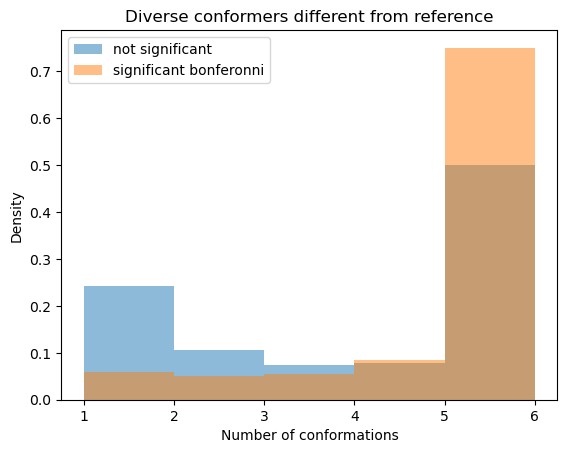

In [ ]:
#but is this because of flexibility? lets look
molregnos_not_significant = list(set(molregnos_not_significant))
molregnos_with_significant = list(set(molregnos_with_significant))
molregnos_with_significant_bonferonni = list(set(molregnos_with_significant_bonferonni))
confs_not_significant = [molregno_to_ncfons[molregno] for molregno in molregnos_not_significant]
confs_significant = [molregno_to_ncfons[molregno] for molregno in molregnos_with_significant]
confs_significant_bonferonni = [molregno_to_ncfons[molregno] for molregno in molregnos_with_significant_bonferonni]
#plot these three in histogram
import matplotlib.pyplot as plt
import numpy as np
plt.hist(confs_not_significant,bins=np.arange(1,7,1),alpha=0.5,label="not significant",density=True)
# plt.hist(confs_significant,bins=np.arange(1,7,1),alpha=0.5,label="significant",density=True)
plt.hist(confs_significant_bonferonni,bins=np.arange(1,7,1),alpha=0.5,label="significant bonferonni",density=True)
plt.legend()
plt.xlabel("Number of conformations")
plt.ylabel("Density")
plt.title("Diverse conformers different from reference")
plt.show()

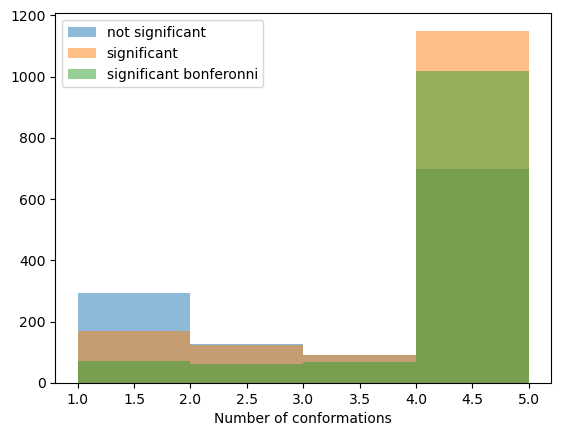

In [ ]:
plt.hist(confs_not_significant,bins=np.arange(1,6,1),alpha=0.5,label="not significant")
plt.hist(confs_significant,bins=np.arange(1,6,1),alpha=0.5,label="significant")
plt.hist(confs_significant_bonferonni,bins=np.arange(1,6,1),alpha=0.5,label="significant bonferonni")
plt.xlabel("Number of conformations")
plt.legend()
plt.show()

In [ ]:
#lets look at the distributions manually for one of these with significant differences

In [ ]:
# molregno_to_look_at = int(molregnos_with_significant[0])
# molregno_to_look_at
# #get the one conf and the many confs
confid_one = confids_one[molregnos.index(molregno_to_look_at)]
confid_many = confids_many[molregnos.index(molregno_to_look_at)]

In [ ]:
molregno_to_look_at

411

In [ ]:
molregno =411
with open("molregno_to_confid_one.pickle","rb") as f:
    molregno_to_confid_one = pickle.load(f)
with open("molregno_to_confid_many.pickle","rb") as f:
    molregno_to_confid_many = pickle.load(f)
    
def get_distributions(confid):
    traj = md.load(f"data/trajectories/{confid}.h5")
    rdk_pmd = pickle.load(open(f"data/topologies/{confid}.pickle", "rb"))
    energie_dict = WaterExtractor.extract_energies(mdtraj_obj=traj,parmed_obj=rdk_pmd)
    rgyr_dict = WaterExtractor.extract_rgyr(mdtraj_obj=traj,parmed_obj=rdk_pmd)
    sasa_dict = WaterExtractor.extract_sasa(mdtraj_obj=traj,parmed_obj=rdk_pmd)
    water_rgyr = rgyr_dict["water_rgyr"]
    water_sasa = sasa_dict["water_sasa"]
    water_sasa = [item for sublist in water_sasa for item in sublist]
    water_intra_crf = energie_dict["water_intra_crf"]
    water_intra_lj = energie_dict["water_intra_lj"]
    water_total_crf = energie_dict["water_total_crf"]
    water_total_lj = energie_dict["water_total_lj"]
    water_intra_ene = energie_dict["water_intra_ene"]
    water_total_ene = energie_dict["water_total_ene"]

    return [water_rgyr,water_sasa,water_intra_crf,water_intra_lj,water_total_crf,water_total_lj,water_intra_ene,water_total_ene]

ref_conf = molregno_to_confid_one[molregno]
test_confs = molregno_to_confid_many[molregno]
nested_list_ref = get_distributions(ref_conf)
stats_list = []
nested_list_nested = []
for conf in test_confs:
    nested_list_test = get_distributions(conf)
    nested_list_nested.append(nested_list_test)


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [ ]:
for i1,lst in enumerate(nested_list_nested):
    stats = get_k2s_stats(nested_list_ref,lst)
    for i,stat in enumerate(stats):
        pval = stat.pvalue
        if pval < 0.05:
            print(pval,i,i1)
        


0.03479508043637821 4 0
0.03479508043637821 6 0
0.04950261174890187 7 1
0.01343088815558133 0 2
0.01637912818629415 2 2
0.008922221390371415 2 3
0.008922221390371415 6 3
0.005832082533064598 6 4


In [ ]:
nested_list_ref[6]
nested_list_nested[4][6]
get_k2s_stats(nested_list_ref,nested_list_nested[4])
ks_2samp(nested_list_ref[6],nested_list_nested[4][6])

KstestResult(statistic=0.108, pvalue=0.005832082533064598, statistic_location=-34.009867478983736, statistic_sign=-1)

-33.34605110934061 -33.50453366213282
-33.55766706865411 -33.7626581359131
1.3742744664922486 1.4419941776952694


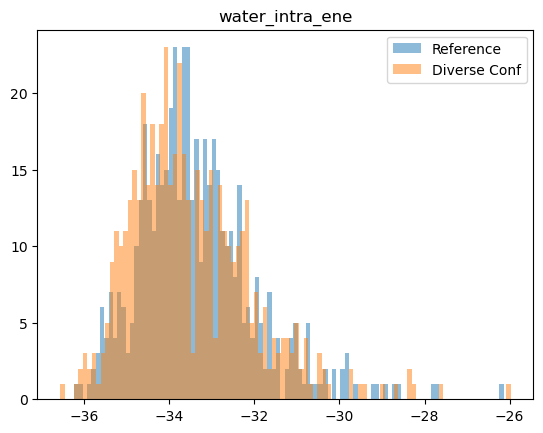

In [ ]:
#okay so lets plot
plt.hist(nested_list_ref[6],bins=100,alpha=0.5,label="Reference")
plt.hist(nested_list_nested[4][6],bins=100,alpha=0.5,label="Diverse Conf")
#print means, medians, stds
print(np.mean(nested_list_ref[6]),np.mean(nested_list_nested[4][6]))
print(np.median(nested_list_ref[6]),np.median(nested_list_nested[4][6]))
print(np.std(nested_list_ref[6]),np.std(nested_list_nested[4][6]))
plt.title('water_intra_ene')
plt.legend()

-33.34605110934061 -33.34605110934061
-33.55766706865411 -33.55766706865411
1.3742744664922486 1.3742744664922486


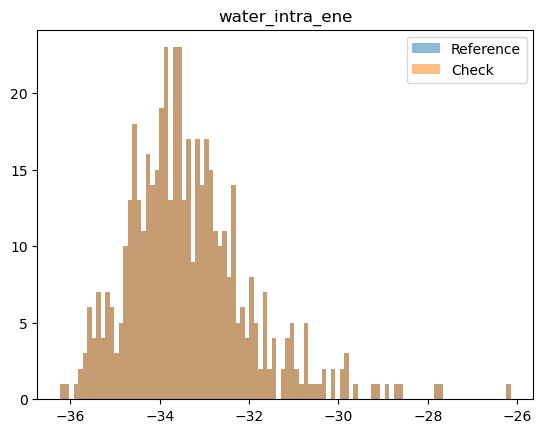

In [ ]:

traj = md.load(f"data/trajectories/{confid_one}.h5")
rdk_pmd = pickle.load(open(f"data/topologies/{confid_one}.pickle", "rb"))
energie_dict = WaterExtractor.extract_energies(mdtraj_obj=traj,parmed_obj=rdk_pmd)
water_total_lj = energie_dict["water_intra_ene"]
#okay so lets plot
plt.hist(nested_list_ref[6],bins=100,alpha=0.5,label="Reference")
plt.hist(water_total_lj,bins=100,alpha=0.5,label="Check")
#print means, medians, stds
print(np.mean(nested_list_ref[6]),np.mean(water_total_lj))
print(np.median(nested_list_ref[6]),np.median(water_total_lj))
print(np.std(nested_list_ref[6]),np.std(water_total_lj))
plt.title('water_intra_ene')
plt.legend()

In [ ]:
#eight subplots, all histograms with overlap of five distributions. subplot per property
dist_lists = []
for conf in range(7622,7627):
    print(conf)
    nested_list_test = get_distributions(conf)
    dist_lists.append(nested_list_test)

7622
7623
7624
7625
7626


In [ ]:
nested_list_ref = get_distributions(3286)

In [ ]:
dist_lists.append(nested_list_ref)

In [ ]:
def avg_std(data):
    avg = np.mean(data)
    std = np.std(data)
    return str(round(avg,2))+'$\pm$'+str(round(std,2))

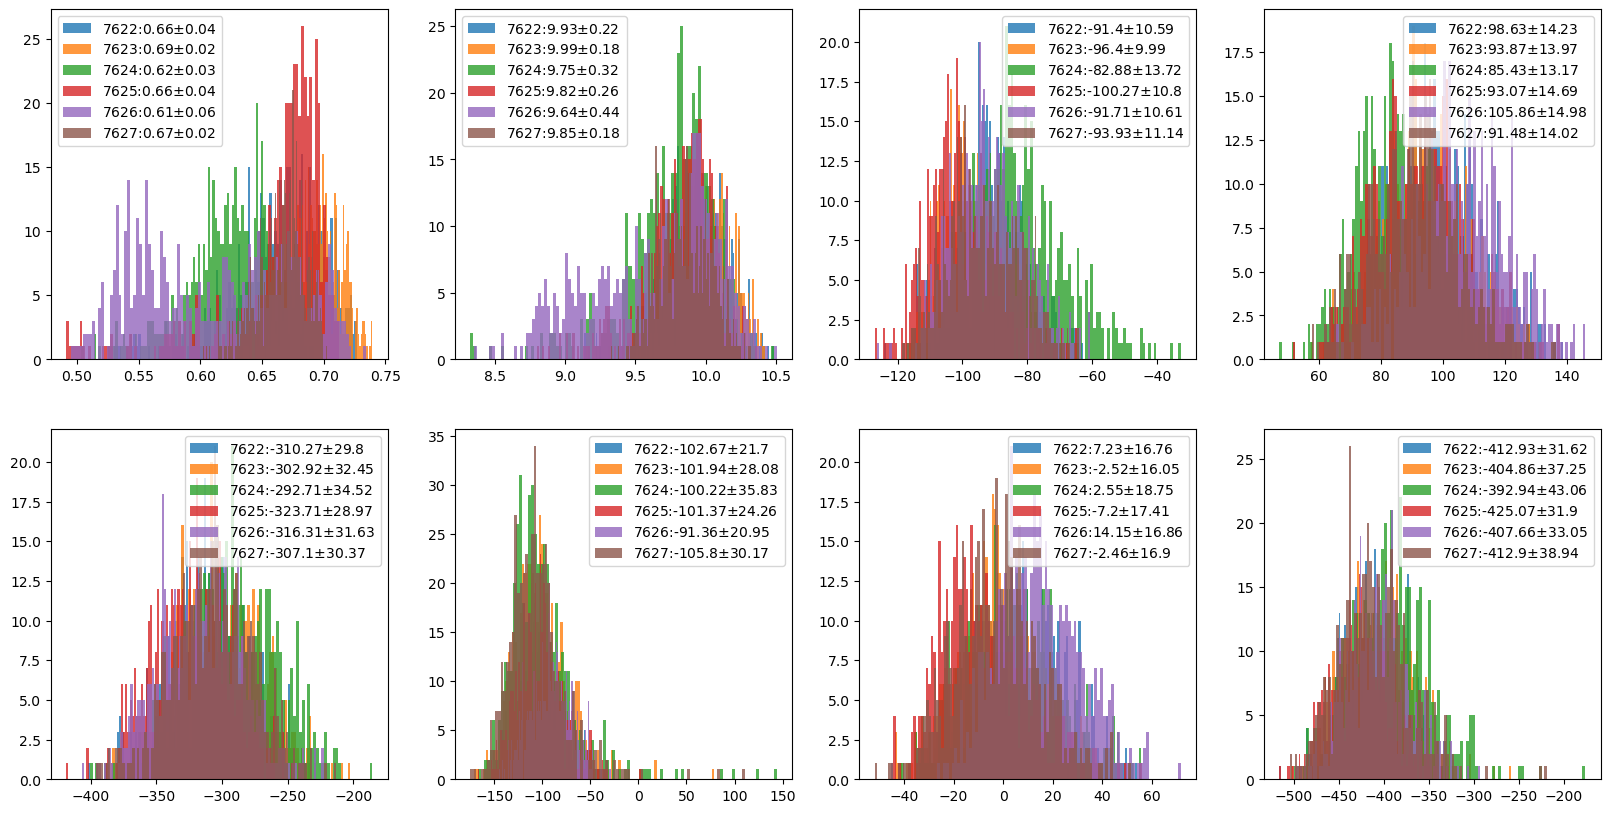

In [ ]:
#dist_lists is a list of lists, each sublist is for one conformer. these sublists contain the distributions for each property
#lets plot them
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(2, 4,figsize=(20,10))
axs = axs.ravel()
labels = ["water_rgyr","water_sasa","water_intra_crf","water_intra_lj","water_total_crf","water_total_lj","water_intra_ene","water_total_energy"]
for i,ax in enumerate(axs):
    for j in range(6):
        
        ax.hist(dist_lists[j][i],bins=100,alpha=0.8,label=str(7622+j)+':'+avg_std(dist_lists[j][i]))
        
    #ax.hist(dist_lists[1][i],bins=100,alpha=0.2,label="7623")
    #ax.hist(dist_lists[2][i],bins=100,alpha=0.2,label="7624")
    #ax.hist(dist_lists[3][i],bins=100,alpha=0.2,label="7625")
    #ax.hist(dist_lists[4][i],bins=100,alpha=0.2,label="7626")
    #ax.hist(dist_lists[5][i],bins=100,alpha=0.8,label="3286")
    #ax.set_title(f"{labels[i]}")
    ax.legend()

In [26]:
import glob
files = glob.glob('data/distribution_stats/*')

print(len(files))

1812


In [29]:
test = pickle.load(open(files[0],"rb"))
len(test)

5